# Forest Fire Detection System - Main Workflow

This Jupyter Notebook serves as the main entry point for the Forest Fire Detection System. It orchestrates the entire workflow, from data preprocessing and dataset creation to model training, evaluation, and hyperparameter tuning. Each step can be run independently or sequentially.
https://firms.modaps.eosdis.nasa.gov/descriptions/FIRMS_VIIRS_Firehotspots.html

acquired time is UTC

## 1. Setup and Configuration

In [1]:
import os
import sys
import logging

# Add 'aad' directory to sys.path for module imports
sys.path.insert(0, os.path.abspath("aad"))

from aad.common.config import Config
from aad.common.reload_all import reload_all
import aad.autoencoder.trainer_standard as trainer_standard
import aad.autoencoder.utils as utils
import aad.autoencoder.evaluator as evaluator
#import aad.model_tuning as model_tuning
import aad.autoencoder.clustering as clustering
from aad.data.utils import create_full_dataloader
from aad.common.core_logging import ProcessLogger

# Configure logging for better output in the notebook
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Initialize configuration
# You can change these paths as needed
DATA_DIR = "data"

OUTPUT_DIR = f'ff_data/output_120min_7h'
MODEL_DIR = f'model_120min_7h'
DATASET_DIR = f'dataset_120min_7h'

# Set environment variables for the Config class to pick up
os.environ['OUTPUT_DIR'] = OUTPUT_DIR
os.environ['MODEL_DIR'] = MODEL_DIR
os.environ['DATASET_DIR'] = DATASET_DIR
os.environ['DATA_DIR'] = DATA_DIR

config = Config()
config.data_pipeline.LOCAL_OFFSET_MINUTES = 420
config.data_pipeline.WINDOW_DURATION_MINUTES = 120

print(f'Processing with window size {120} minutes and offset 7h')

config = Config()

print(f"Using data directory: {config.paths.DATA_DIR}")
print(f"Using output directory: {config.paths.OUTPUT_DIR}")
print(f"Using model directory: {config.paths.MODEL_DIR}")

# Ensure directories exist (Config() constructor already does this, but explicit is fine)
os.makedirs(config.paths.DATA_DIR, exist_ok=True)
os.makedirs(config.paths.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.paths.MODEL_DIR, exist_ok=True)

Processing with window size 120 minutes and offset 7h
Using data directory: data
Using output directory: ff_data/output_120min_7h
Using model directory: model_120min_7h


## 4. Train the Autoencoder Model

This section trains the autoencoder neural network using the prepared dataset. The model learns to reconstruct normal environmental patterns, which is crucial for anomaly detection.

In [2]:
# ForestFireDetection.ipynb

import logging
from aad.autoencoder.trainer_standard import StandardTrainer
from aad.autoencoder.model_vae import VariationalAutoencoder
from aad.autoencoder.model_dense import Autoencoder
from aad.data.utils import create_dataloaders
from aad.common.reload_all import reload_all  # Explicit import for clarity

num_features = len(config.data_pipeline.INPUT_COLUMNS) + len(config.data_pipeline.INPUT_COLUMNS) * len(config.data_pipeline.SMA_MULTIPLIERS) * 4 # 3 is sma, median, min and max
config.training.BATCH_SIZE = 256
config.tuning.LATENT_DIM = 24


model = Autoencoder(
    time_steps=60,
    #time_steps=config.data_pipeline.WINDOW_SIZE,
    num_features=num_features,
    latent_dim=config.tuning.LATENT_DIM,
    dropout=0.0,
    d_model=num_features,
    num_heads=3,
)


/opt/conda/envs/py_3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## 5. Evaluate the Model

After training, the model is evaluated to assess its performance in detecting anomalies. This step calculates reconstruction errors, applies anomaly thresholds, and compares predictions against ground truth fire events to compute metrics like precision, recall, and F1-score.

In [3]:
import aad.autoencoder.evaluator as evaluator
import torch
from importlib import reload 

config.training.DEVICE = "cuda"
config.training.BATCH_SIZE = 256

test_loader = create_full_dataloader(
    config.paths.DATASET_PATH,
    None,
    config.training.RANDOM_SEED,
    config.training.BATCH_SIZE,
    ProcessLogger(config, "dataloader"),
)

reload(evaluator)

logger = ProcessLogger(config, "evaluator")
model.load_state_dict(torch.load(config.paths.BEST_MODEL_PATH, config.training.DEVICE))
config.training.ANOMALY_THRESHOLD_PERCENTILE = 99.98
config.training.DISTANCE_FILTER_THRESHOLD_M = 7000
evaluator = evaluator.ModelEvaluator(
    distance_filter_threshold_m=config.training.DISTANCE_FILTER_THRESHOLD_M,
    device=config.training.DEVICE,
    logger=logger,
    model=model,
    test_loader=test_loader,
    stats_images_dir=config.paths.STATS_IMAGES_DIR,
    stats_csv_dir=config.paths.STATS_CSV_DIR,
    eval_stats_img_path=config.paths.EVALUATION_STATISTICS_IMAGE_PATH,
    eval_results_csv_path=config.paths.EVALUATION_RESULTS_CSV_PATH,
    eval_summary_json_path=config.paths.EVALUATION_SUMMARY_JSON_PATH,
)

anomaly_scores, all_window_ids, all_fire_ids, all_distances  = evaluator.compute_anomaly_scores()


INFO: [dataloader] Dataset loaded successfully


2025-09-02 15:19:09,564 - INFO - [dataloader] Dataset loaded successfully


INFO: [evaluator] ModelEvaluator initialized with device=cuda, model=Autoencoder, test_loader=DataLoader


2025-09-02 15:19:09,958 - INFO - [evaluator] ModelEvaluator initialized with device=cuda, model=Autoencoder, test_loader=DataLoader


INFO: [evaluator] Computing anomaly scores


2025-09-02 15:19:09,959 - INFO - [evaluator] Computing anomaly scores


Computing anomaly scores:   0%|          | 0/2364 [00:00<?, ?it/s]

INFO: [evaluator] Anomaly scores computed


2025-09-02 15:19:46,339 - INFO - [evaluator] Anomaly scores computed


INFO: [evaluator] Starting model evaluation


2025-09-02 15:23:12,442 - INFO - [evaluator] Starting model evaluation


INFO: [evaluator] Anomaly threshold computed


2025-09-02 15:23:12,453 - INFO - [evaluator] Anomaly threshold computed


INFO: [evaluator] Creating true labels with fire IDs and distance filtering


2025-09-02 15:23:12,455 - INFO - [evaluator] Creating true labels with fire IDs and distance filtering


INFO: [evaluator] True labels created with distance filtering


2025-09-02 15:23:12,463 - INFO - [evaluator] True labels created with distance filtering


INFO: [evaluator] Evaluation metrics calculated


2025-09-02 15:23:12,477 - INFO - [evaluator] Evaluation metrics calculated


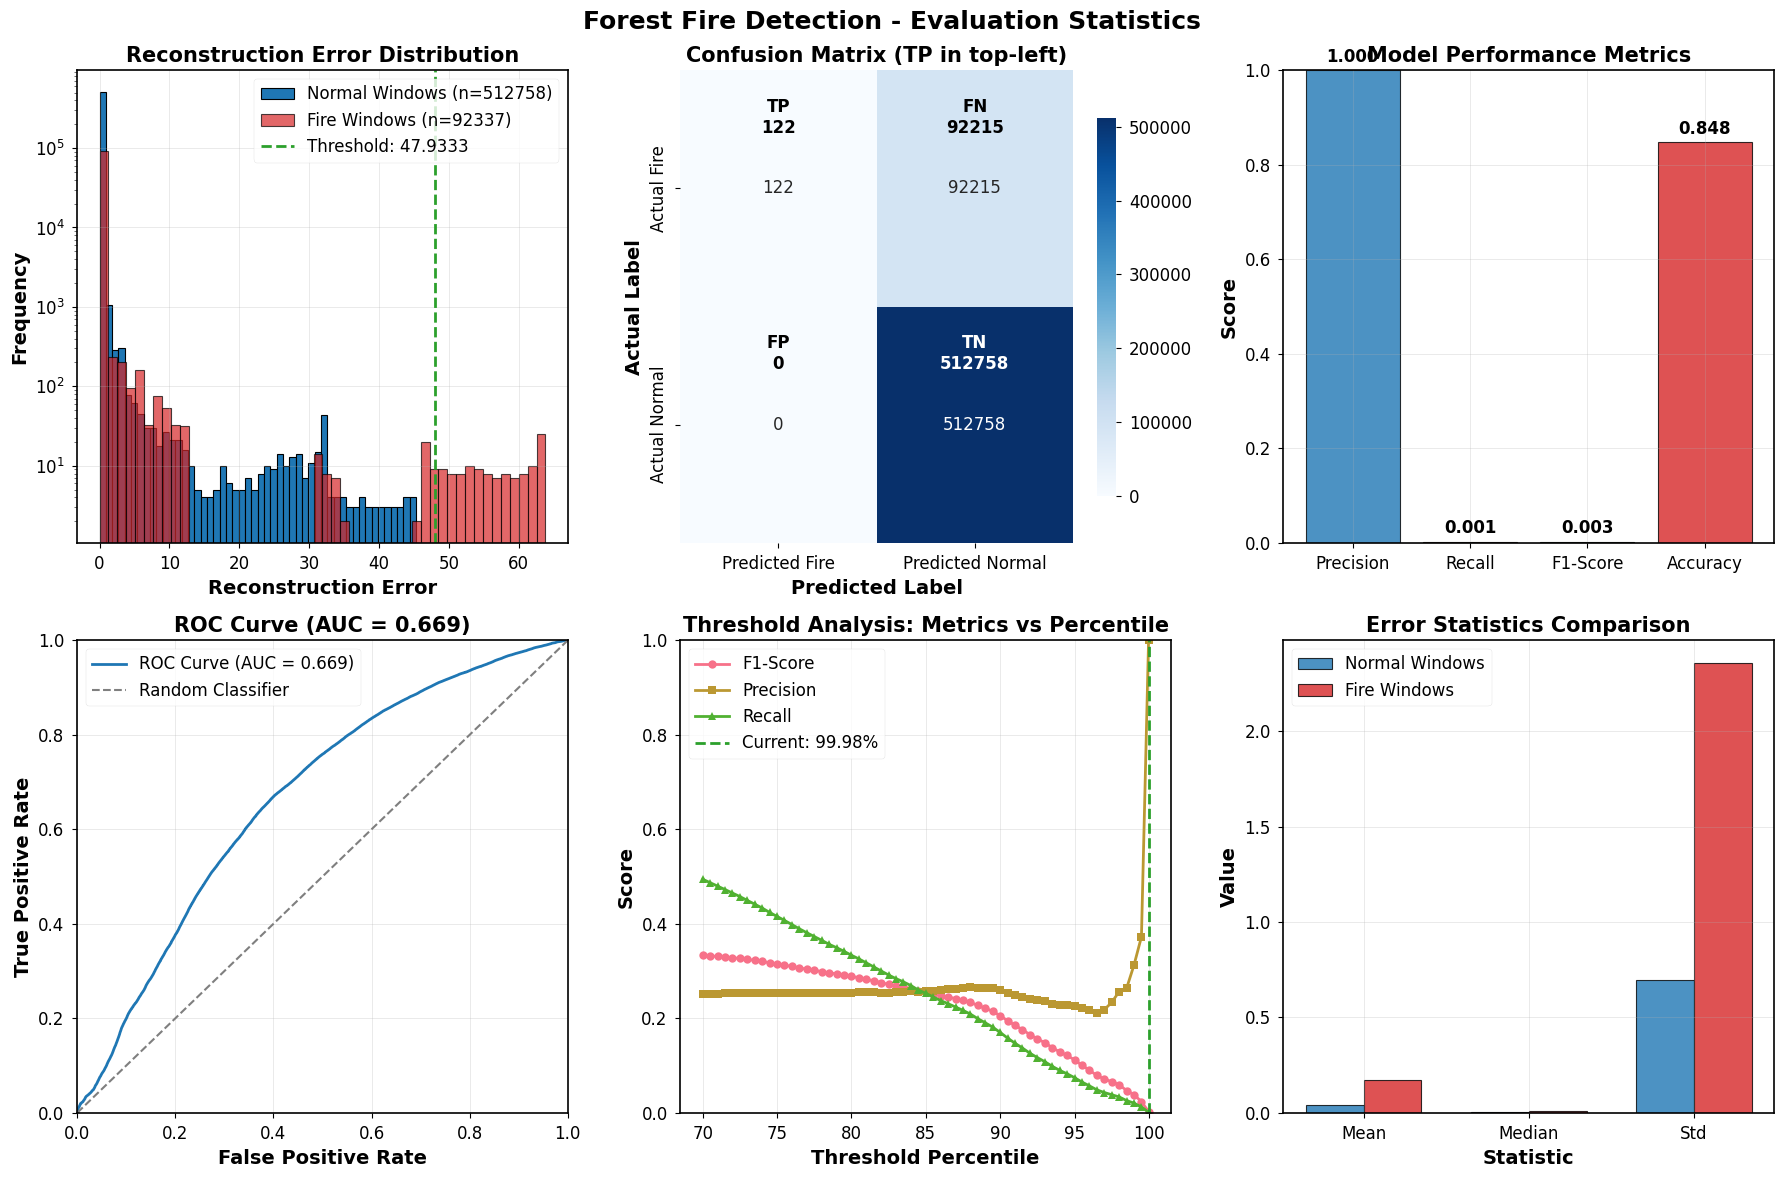

INFO: [evaluator] Evaluation statistics saved to: ff_data/output_120min_7h/stats/images/evaluation_statistics.png


2025-09-02 15:23:25,345 - INFO - [evaluator] Evaluation statistics saved to: ff_data/output_120min_7h/stats/images/evaluation_statistics.png


INFO: [evaluator] Evaluation results saved to ff_data/output_120min_7h/stats/csv/evaluation_results.csv and ff_data/output_120min_7h/stats/csv/evaluation_summary.json


2025-09-02 15:23:26,281 - INFO - [evaluator] Evaluation results saved to ff_data/output_120min_7h/stats/csv/evaluation_results.csv and ff_data/output_120min_7h/stats/csv/evaluation_summary.json


INFO: Process timeline saved to ff_data/output_120min_7h/stats/images/evaluator_timeline.png


2025-09-02 15:23:27,077 - INFO - Process timeline saved to ff_data/output_120min_7h/stats/images/evaluator_timeline.png


[DEBUG] Plotting metrics: {'total_samples': 605095, 'mean_score': 0.06142212077975273, 'std_score': 1.1236581802368164, 'min_score': 0.00045881856931373477, 'max_score': 63.803375244140625, 'threshold_percentile': 99.98, 'threshold_value': 47.9333025787466, 'predicted_anomalies': 122, 'potential_fire_samples': 474077, 'distance_filtered_fire_samples': 92337, 'normal_samples': 512758, 'distance_threshold_m': 7000, 'true_positives': 122, 'false_positives': 0, 'false_negatives': 92215, 'true_negatives': 512758, 'precision': 1.0, 'recall': 0.0013212471706899726, 'f1_score': 0.0026390075601077233, 'accuracy': 0.8476024425916592, 'specificity': 1.0}
INFO: Metrics plot saved to ff_data/output_120min_7h/stats/images/evaluator_metrics.png


2025-09-02 15:23:27,698 - INFO - Metrics plot saved to ff_data/output_120min_7h/stats/images/evaluator_metrics.png


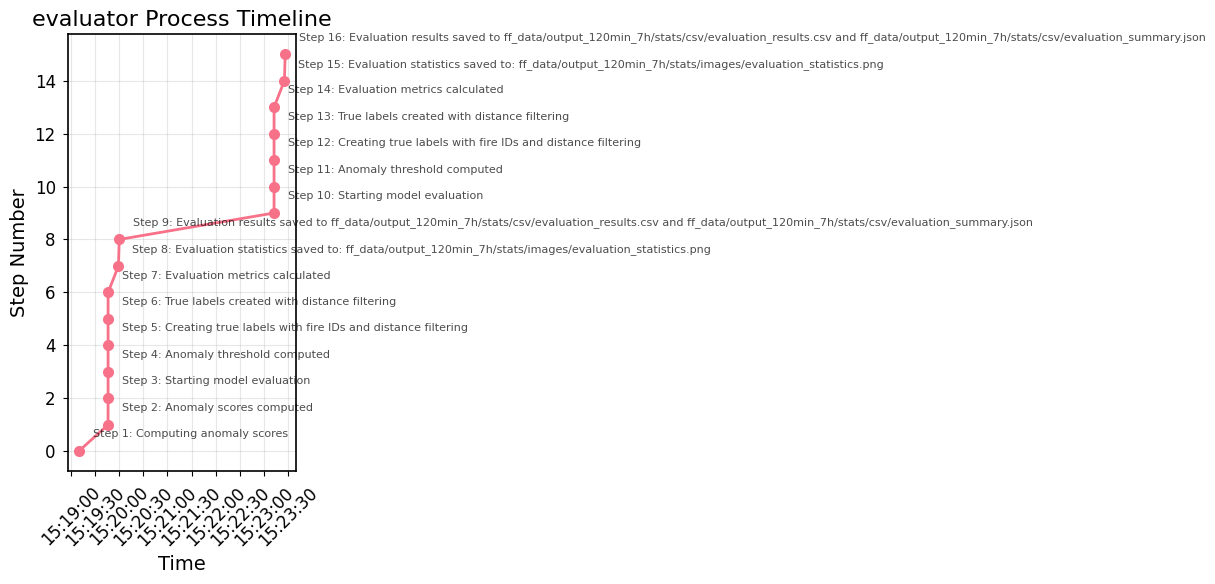

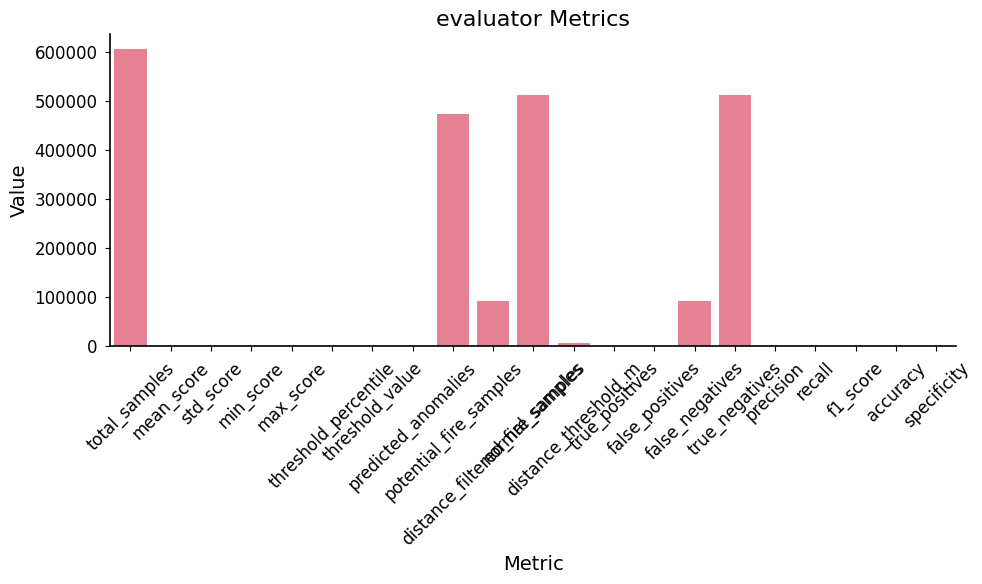

In [6]:
config.training.ANOMALY_THRESHOLD_PERCENTILE = 99.98
result = evaluator.evaluate_model(anomaly_scores, all_window_ids, all_fire_ids, all_distances, config.training.ANOMALY_THRESHOLD_PERCENTILE, True)

In [35]:
import numpy as np
from pathlib import Path
import pandas as pd
import plotly.express as px

true_window = np.unique(result['true_positive_window_ids'])
sensor_files = list(Path('dd/ff_data/output_120min_7h/annotated_data/').glob("sensor_*.parquet"))
if not sensor_files:
    raise ValueError("No annotated sensor data found.")

valid_windows_times = []
for sensor_file in sensor_files:
    df = pd.read_parquet(sensor_file)
    # Adjust these column names to match your data
    valid_df = df[df['window_id'].isin(true_window)]
    # Assuming columns: 'window_start' and 'window_end'
    valid_windows_times.append(valid_df)
    

cc = pd.concat(valid_windows_times)
cc
data = cc.groupby('window_id').agg(
        window_start=('Datetime', 'min'),
        window_end=('Datetime', 'max')
    ).reset_index()

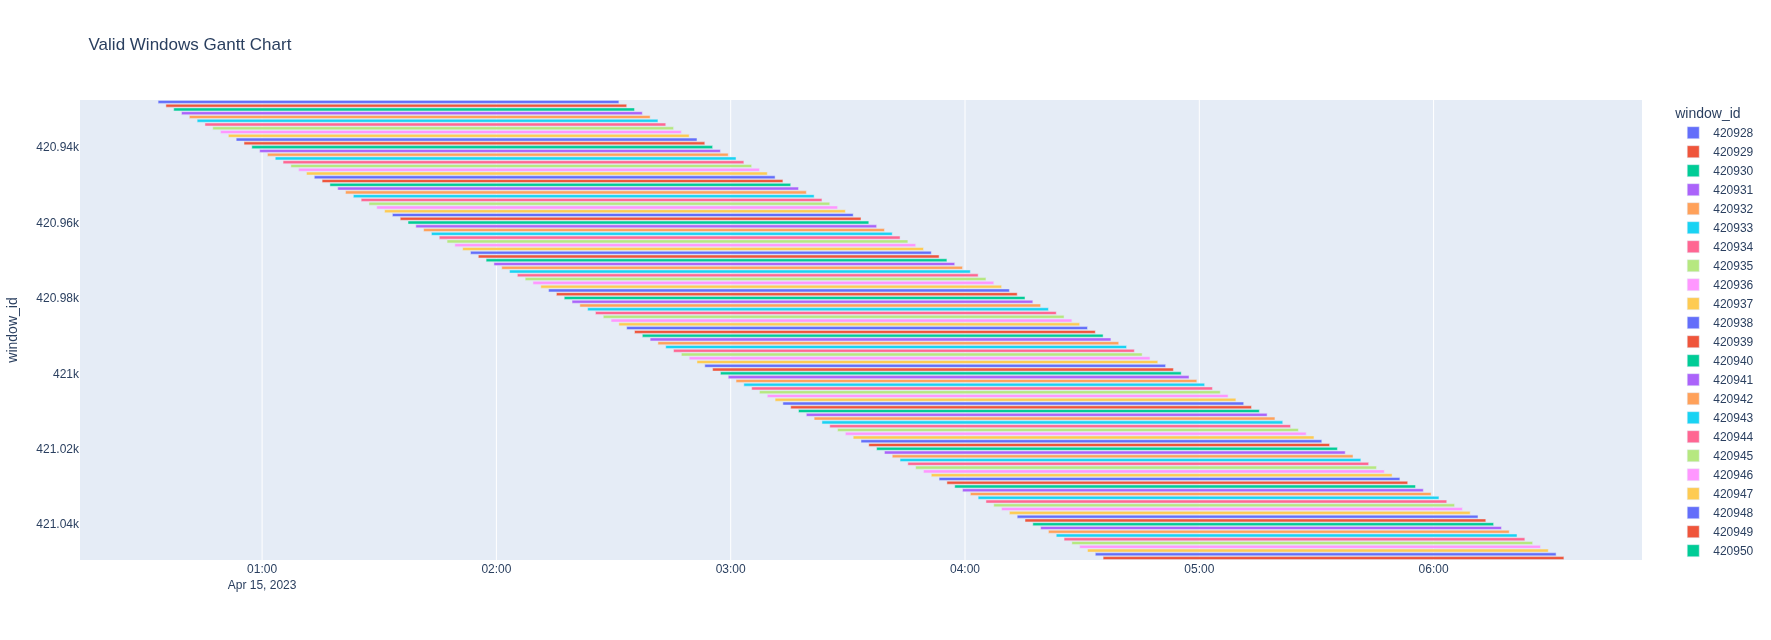

In [43]:
import plotly.express as px

# Ensure your start/end columns are datetime
data['window_start'] = pd.to_datetime(data['window_start'])
data['window_end'] = pd.to_datetime(data['window_end'])
# Convert window_id to categorical
data['window_id'] = data['window_id'].astype('category')

fig = px.timeline(
    data,
    x_start="window_start",
    x_end="window_end",
    y="window_id",          # Each window_id on its own row
    color="window_id",      # Optional: color by window_id
    title="Valid Windows Gantt Chart"
)

fig.update_yaxes(autorange="reversed")  # So earliest window is at the top
fig.update_layout(height=640, width=800)
fig.show()


In [5]:
SKIP_CLUSTERING = False

if not SKIP_CLUSTERING:
    logging.info("--- Performing model clustering for the autoencoder model ---")
    reload_all()
    dataloader = create_full_dataloader(config)
    config.tuning.KMEANS_N_CLUSTERS = 32
    config.tuning.DBSCAN_EPS = 0.5
    config.tuning.DBSCAN_MIN_SAMPLES = 5
    clustering.analyze_embeddings(config, dataloader)
else:
    logging.info("Skipping model clustering for the autoencoder model")

2025-09-02 15:20:01,852 - INFO - --- Performing model clustering for the autoencoder model ---


Reloading modules in directory: /root/fire-detection


TypeError: create_full_dataloader() missing 3 required positional arguments: 'num_samples', 'random_seed', and 'batch_size'

## 6. Hyperparameter Tuning

This optional step performs hyperparameter tuning to optimize the autoencoder's performance. It systematically explores different combinations of latent dimensions, hidden layers, and anomaly thresholds to find the best configuration.

In [ ]:
# Set to True to skip this step
SKIP_HYPERPARAMETER_TUNING = True

if not SKIP_HYPERPARAMETER_TUNING:
    logging.info("--- Performing hyperparameter tuning for the autoencoder model ---")
    #tune_hyperparameters_advanced(config)
else:
    logging.info("Skipping Performing hyperparameter tuning for the autoencoder model")

## Workflow Completed

The entire forest fire detection workflow has been executed. You can now review the generated outputs in the `output/` directory.

### Key Benefits of the Refactored Structure:
- **Clear Module Organization**: Each import now comes from a logically named module
- **Single Responsibility**: Each module has a focused purpose
- **Easy Maintenance**: Code is organized and easy to find
- **No Circular Dependencies**: Clean import structure

### Updated Module Mapping:
- `data_preprocessing` → Data resampling and windowing
- `data_filtering` → Window and distance filtering  
- `data_annotation` → Fire distance calculations
- `data_sequences` → Dataset creation and sequences
- `model_training` → Autoencoder training workflow
- `eval_metrics` → Model evaluation and metrics
- `eval_tuning` → Hyperparameter optimization